# Code to generate Fig. 3

Below is the code used to recreate Fig. 3. See the main text for more details .

In [1]:
## Import packages

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import multinetx as mx
import scipy.io as sio
import pandas as pd
import os
import sys
import csv
import scipy as sp

# Import mx viz functions
import mx_viz

print("Done importing packages :)")

finished defining functions
Done importing packages :)


## Create the multilayer network

Using multinetx, we will create a multilayer (mx) network to represent the data. In this case, all nodes exist in every layer and each node connects only to its counterpart in adjacent layers.

Text(0.5, 1.0, 'g3')

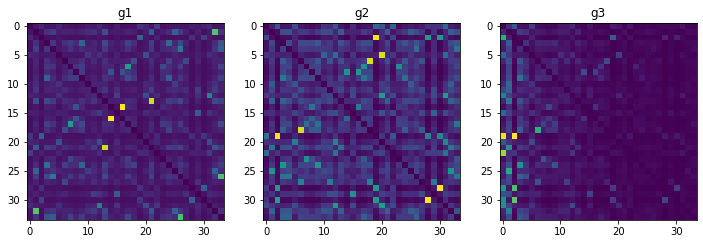

In [2]:
# Set the number of nodes
nNodes = 34

# Define number of levels (L2).
nLayers = 3

## Read in data and create individual layers g1, g2, g3

# open and write g1 as one over distance dorado
with open('data/oodahat_dorado.csv', newline='') as f:
    reader = csv.reader(f)
    distances = list(reader)
    
stars = np.arange(1,35,1)
g1 = nx.DiGraph()
g1.add_nodes_from(stars)

for r in stars:
    for c in stars:
        
        # Add edge if r != c to avoid self-loops
        if r!= c:
            g1.add_edge(r,c,weight=float(distances[r-1][c-1]))
        

# open and write g2 as saccade dorado        
with open('data/saccahat_dorado.csv', newline='') as f:
    reader = csv.reader(f)
    distances = list(reader)
    
stars = np.arange(1,35,1)
g2 = nx.DiGraph()
g2.add_nodes_from(stars)

for r in stars:
    for c in stars:
        if r != c:
            g2.add_edge(r,c,weight=float(distances[r-1][c-1]))


# open and write g3 as mags dorado
with open('data/magsahat_dorado.csv', newline='') as f:
    reader = csv.reader(f)
    distances = list(reader)
    
stars = np.arange(1,35,1)
g3 = nx.DiGraph()
g3.add_nodes_from(stars)

for r in stars:
    for c in stars:
        if r !=c:
            g3.add_edge(r,c,weight=float(distances[r-1][c-1]))

        
## Plot to check out our matrices -- note that only g3 is directed

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True,
                                    figsize=(12, 6))
ax0.imshow(nx.adjacency_matrix(g1,weight='weight').todense())
ax0.set_title('g1')

ax1.imshow(nx.adjacency_matrix(g2,weight='weight').todense())
ax1.set_title('g2')

ax2.imshow(nx.adjacency_matrix(g3,weight='weight').todense())
ax2.set_title('g3')


## Build the multilayer network

Through graph unions, we will create a large supra-adjacency matrix. We will use this supra-adjacency matrix later to finally write the data to the visualization files.

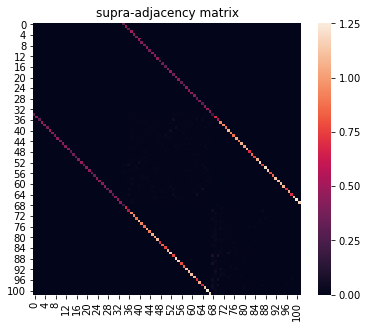

In [3]:
## Create the unioned graph

union1 = nx.disjoint_union(g1,g2)
graph_union = nx.disjoint_union(union1, g3)


## Calculate and assign inter-layer weights

# Record edge weights for easy calculations of stroke-width map later
strength_diff_g1g2 = []
strength_diff_g2g3 = []

# Interate over connected node pairs for g1, g2 and assign inter-layer edge weights
for node1 in np.arange(nNodes) :
    
    # Find node1's pair in the second layer
    node2 = node1 + nNodes
    
    # Calculate edge weight as absolute value of difference in node strengths
    strength_diff = abs(graph_union.degree(weight="weight")[node1] - graph_union.degree(weight="weight")[node2])
    if strength_diff == 0:
        print(graph_union.degree(weight="weight")[node1])
        print(graph_union.degree(weight="weight")[node2])
    
    
    # Assign edge weights
    graph_union.add_edge(node1,node2,weight = strength_diff)
    graph_union.add_edge(node2,node1,weight = strength_diff)
    
    # Add to list
    strength_diff_g1g2.append(strength_diff)
    

# Repeat for connecting layers 2,3
for node1 in np.arange(nNodes,2*nNodes) :
    
    # Find node1's pair in the second layer
    node2 = node1 + nNodes
    
    # Calculate edge weight as absolute value of difference in node strengths
    strength_diff = abs(graph_union.degree(weight="weight")[node1] - graph_union.degree(weight="weight")[node2])
    
    # Assign edge weght
    graph_union.add_edge(node1,node2,weight = strength_diff)
    graph_union.add_edge(node2,node1,weight = strength_diff)
    
    # Add to list
    strength_diff_g2g3.append(strength_diff)
    

# Plot supra-adjacency matrix
fig = plt.figure(figsize=(6,5))
sns.heatmap(nx.adjacency_matrix(graph_union,weight='weight').todense())
plt.title('supra-adjacency matrix');

## Calculate domains for visualization data maps

For simplicity, we will calculate values needed for visualization data maps (color, stroke-width) below.  

In [4]:
## Print necessary values for data mappings

print(f'The range for the strength_diff_g1g2 list is [{min(strength_diff_g1g2)}, {max(strength_diff_g1g2)}]')
print(f'The range for the strength_diff_g2g3 list is [{min(strength_diff_g2g3)}, {max(strength_diff_g2g3)}]')
print(f'The range for the g1 edge weights is [{min([data["weight"] for u,v,data in g1.edges(data=True)])}, {max([data["weight"] for u,v,data in g1.edges(data=True)])}]')
print(f'The range for the g2 edge weights is [{min([data["weight"] for u,v,data in g2.edges(data=True)])}, {max([data["weight"] for u,v,data in g2.edges(data=True)])}]')
print(f'The range for the g3 edge weights is [{min([data["weight"] for u,v,data in g3.edges(data=True)])}, {max([data["weight"] for u,v,data in g3.edges(data=True)])}]')


The range for the strength_diff_g1g2 list is [0.2962678991395554, 0.5077106548276319]
The range for the strength_diff_g2g3 list is [0.21226225640222707, 1.2517039644200691]
The range for the g1 edge weights is [0.000153587620198769, 0.00449748965180842]
The range for the g2 edge weights is [0.000317446680949248, 0.0474290975274551]
The range for the g3 edge weights is [5.50733995541178e-05, 0.0855367990501473]


### Write to json and create visualization.

The first mx_viz function writes the graph to a json file, while the second reads the file and creates an html file with the visualization. 

Below we will only the light theme using the parameter `theme="light"`.

In [12]:
## Define node positions based on the data
with open('data/x.csv', newline='') as f:
    reader = csv.reader(f, quoting=csv.QUOTE_NONNUMERIC)
    x_coor = list(reader)
    
with open('data/y.csv', newline='') as f:
    reader = csv.reader(f, quoting=csv.QUOTE_NONNUMERIC)
    y_coor = list(reader)
    
with open('data/z.csv', newline='') as f:
    reader = csv.reader(f, quoting=csv.QUOTE_NONNUMERIC)
    z_coor = list(reader)    

keys = range(1,35)
vals = []
scale_factor = 4
for i in range(len(x_coor)):
    vals.append([scale_factor*x_coor[i][0], scale_factor*y_coor[i][0], z_coor[i][0]])

    
pos = {}
for i in keys:
     pos[keys[i-1]] = vals[i-1]

## Write to outputs

filename_json = "data/example2.json"
G2 = mx_viz.write_supraadj_to_json(filename_json,graph_union, nNodes, pos, nLayers)

filename_html_light = "visualization_output_fig3_light.html"
mx_viz.visualize(G2,theme="light",path_html=filename_html_light);

done writing mx to data/example2.json
Wrote visualization to: visualization_output_fig3_light.html
